In [7]:
import pandas as pd
from pandasql import sqldf
import json
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pyarrow.parquet as pq

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

# To suppress numeric values from being returned in exponential format
pd.options.display.float_format = '{:20,.2f}'.format

# To display all charts against a white background
plt.style.use('seaborn-whitegrid')

In [14]:
f = open('..\\conf\\sales_conf.json')
conf_data = json.load(f)


In [9]:
raw_df = {}
indexed_df = {}

In [10]:
def load_data(load_func):
    df = eval(load_func)

    return df

In [11]:
for key, value in raw_df.items():
    print("Key: ", key)
    print(type(value))

In [12]:
def set_key(df, index):
    df_indexed = df.set_index(index)
    return df_indexed

In [15]:
for i in conf_data["tables"]:
    raw_df[i["raw_df"]] = load_data(conf_data["pandas_module"] + i["load_func"] + "('" + conf_data["file_path"] + i["file_name"] + "')")

In [16]:
for key, value in raw_df.items():
    print("Key: ", key)
    print(type(value))

Key:  contact_df_raw
<class 'pandas.core.frame.DataFrame'>
Key:  customer_df_raw
<class 'pandas.core.frame.DataFrame'>
Key:  product_df_raw
<class 'pandas.core.frame.DataFrame'>
Key:  state_df_raw
<class 'pandas.core.frame.DataFrame'>
Key:  txn_df_raw
<class 'pandas.core.frame.DataFrame'>
Key:  touch_df_raw
<class 'pandas.core.frame.DataFrame'>


In [17]:
for i in conf_data["tables"]:
    indexed_df[i["indexed_df"]] = set_key(raw_df[i["raw_df"]], i["index_col"])


In [18]:
for key, value in indexed_df.items():
    print("Key: ", key)
    print(type(value))


Key:  contact_df
<class 'pandas.core.frame.DataFrame'>
Key:  customer_df
<class 'pandas.core.frame.DataFrame'>
Key:  product_df
<class 'pandas.core.frame.DataFrame'>
Key:  state_df
<class 'pandas.core.frame.DataFrame'>
Key:  txn_df
<class 'pandas.core.frame.DataFrame'>
Key:  touch_df
<class 'pandas.core.frame.DataFrame'>


In [19]:
# Loading data into dataframes using Pandas
contact_df = indexed_df['contact_df']
customer_df = indexed_df['customer_df']
product_df = indexed_df['product_df']
state_df = indexed_df['state_df']
txn_df = indexed_df['txn_df']
touch_df = indexed_df['touch_df']


In [20]:
print('Contact (rows): %d' %contact_df.shape[0])
print('Customer (rows): %d' %customer_df.shape[0])
print('Product (rows): %d' %product_df.shape[0])
print('State (rows): %d' %state_df.shape[0])
print('Transactions (rows): %d' %txn_df.shape[0])
print('Touches (rows): %d' %touch_df.shape[0])


Contact (rows): 210002
Customer (rows): 3876
Product (rows): 426
State (rows): 50
Transactions (rows): 90010
Touches (rows): 16974


In [21]:
query = "select * from contact_df limit 10"
sqldf(query, globals())

,contact_id,first_name,last_name,city,state_code,zip,country,latitude,longitude,customer_id,status,opportunity
0,100000339,Lyndy,Chachas,Omaha,NE,68130,USA,41.23,-96.18,450058148,Active,50000
1,100001423,Watts,Eifenstadt,Weston,FL,33326,USA,26.10,-80.36,450059017,Active,50000
2,100001837,Jingfeng,Lopina,Hunt Valley,MD,21030,USA,39.50,-76.67,450059076,Active,125000
3,100002544,Gaynell,Vivrett,Beloit,WI,53511,USA,42.50,-89.04,450057762,Active,16000
4,100002551,Peregrino,Valles,New York,NY,10036,USA,40.76,-73.98,450055995,Active,150000
5,100004344,Koby,Musselman,Portland,OR,97223,USA,45.43,-122.75,450058721,Active,18000
6,100005285,Nikos,Mitchell,Saint Augustine,FL,32092,USA,30.06,-81.54,450058073,Active,20000
7,100006388,Alexcameron,Dlubac,Cleveland,OH,44115,USA,41.51,-81.61,450059045,Active,10000
8,100008082,Chien,Channon,Boca Raton,FL,33432,USA,26.35,-80.09,450059246,Active,236000
9,100008458,Uyen,Chow,Princeton,NJ,8540,USA,40.40,-74.66,450059118,Active,305000


In [5]:
# Are higher sales due to a higher number of touches?
query  ='''
select customer_name, count(distinct touch_df.txn_id) as touches, round(sum(txn_df.sales)/100000,2) as sales_100k
from customer_df inner join contact_df on customer_df.customer_id = contact_df.customer_id
    inner join touch_df on contact_df.contact_id = touch_df.contact_id
    inner join txn_df on contact_df.contact_id = txn_df.contact_id
group by 1
having sum(txn_df.sales) > 1000000
limit 25
'''

sales_touches_by_cust_df = sqldf(query, globals())
sales_touches_by_cust_df.head()

,customer_name,touches,sales_100k
0,109-111 GRAHAM AVE LLC,8,47.27
1,122 WATSON LLC,2,12.11
2,"132 HARTSHORN JMPOG, LLC",8,15.88
3,14 FOREST PLACE LLC,14,13.23
4,1438 PARKVIEW LLC,2,12.09


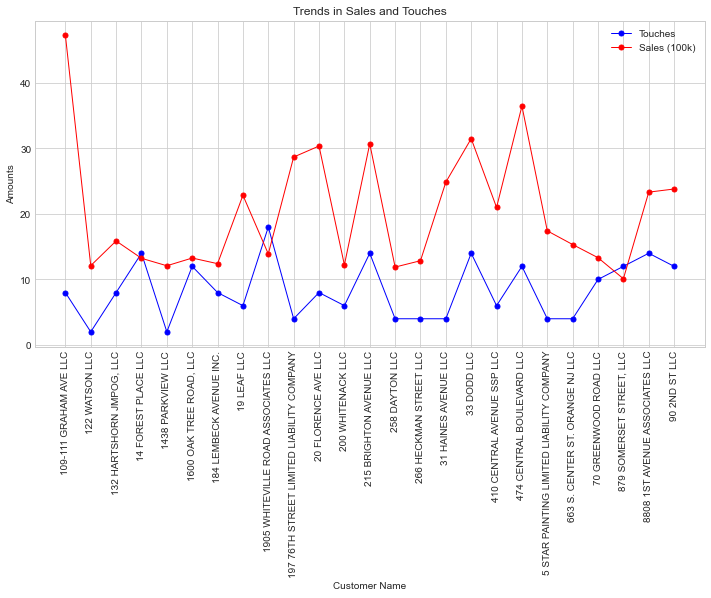

In [67]:
plt.figure(figsize=(12,6))

plt.plot(sales_touches_by_cust_df.customer_name, sales_touches_by_cust_df.touches, color='blue', marker='o', linestyle='solid', linewidth=1, markersize=5, label = 'Touches')
plt.plot(sales_touches_by_cust_df.customer_name, sales_touches_by_cust_df.sales_100k, color='red', marker='o', linestyle='solid', linewidth=1, markersize=5, label = 'Sales (100k)')
plt.legend(loc="upper right")
plt.xlabel('Customer Name')
plt.ylabel('Amounts')
plt.title('Trends in Sales and Touches')
labels = sales_touches_by_cust_df.customer_name
ax = plt.gca()
ax.set_xticklabels(labels = labels, rotation = 90)
plt.show()

In [7]:
# Does a low count in touches result in higher redemptions?
query  ='''
select customer_name, count(touch_df.txn_id) as touches, abs(round(sum(txn_df.redemptions)/10000,2)) as redemptions_10k
from customer_df inner join contact_df on customer_df.customer_id = contact_df.customer_id
    inner join touch_df on contact_df.contact_id = touch_df.contact_id
    inner join txn_df on contact_df.contact_id = txn_df.contact_id
group by 1
having abs(sum(txn_df.redemptions)) > 250000
'''

redemptions_touches_by_cust_df = sqldf(query, globals())
redemptions_touches_by_cust_df.head()

,customer_name,touches,redemptions_10k
0,302 OSBOURNE NJ LLC,70,32.23
1,AL FASSEEH INC.,78,28.41
2,ALL GOOD PANINI AND PIZZA LLC,56,35.89
3,BOUTIQUE NAIL SPA LLC,34,30.60
4,FRESH BUI LLC,50,28.71


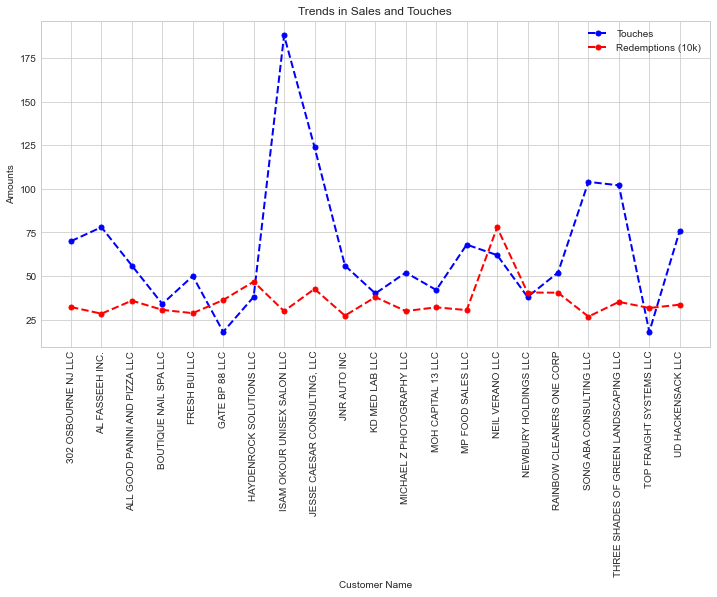

In [66]:
plt.figure(figsize=(12,6))

plt.plot(redemptions_touches_by_cust_df.customer_name, redemptions_touches_by_cust_df.touches, color='blue', marker='o', linestyle='dashed', linewidth=2, markersize=5, label = 'Touches')
plt.plot(redemptions_touches_by_cust_df.customer_name, redemptions_touches_by_cust_df.redemptions_10k, color='red', marker='o', linestyle='dashed', linewidth=2, markersize=5, label = 'Redemptions (10k)')
plt.legend(loc="upper right")
plt.xlabel('Customer Name')
plt.ylabel('Amounts')
plt.title('Trends in Sales and Touches')
plt.legend()
# plt.gca().get_xaxis().get_major_formatter().set_scientific(False)
labels = redemptions_touches_by_cust_df.customer_name
ax = plt.gca()
ax.set_xticklabels(labels = labels, rotation = 90)
plt.show()

In [52]:
# Do all highly sold funds belong to Morning Star Rating 4 and above?
query = '''
select ticker, max(ms_rating) as ms_rating, round(sum(sales), 2)/1000000 as sales_mil
from product_df inner join txn_df on product_df.ticker = txn_df.product_id
group by 1
having sum(sales) > 1000000
order by 3 desc
limit 25
'''

sales_by_product_df = sqldf(query, globals())
sales_by_ticker_df = sales_by_product_df.set_index('ticker')
sales_by_ticker_df.head()

,ms_rating,sales_mil
ticker,,
VSCGX,4,8.72
VFINX,4,8.68
MCHFX,3,8.13
WASCX,2,7.71
VFICX,3,7.56


<AxesSubplot:xlabel='ticker'>

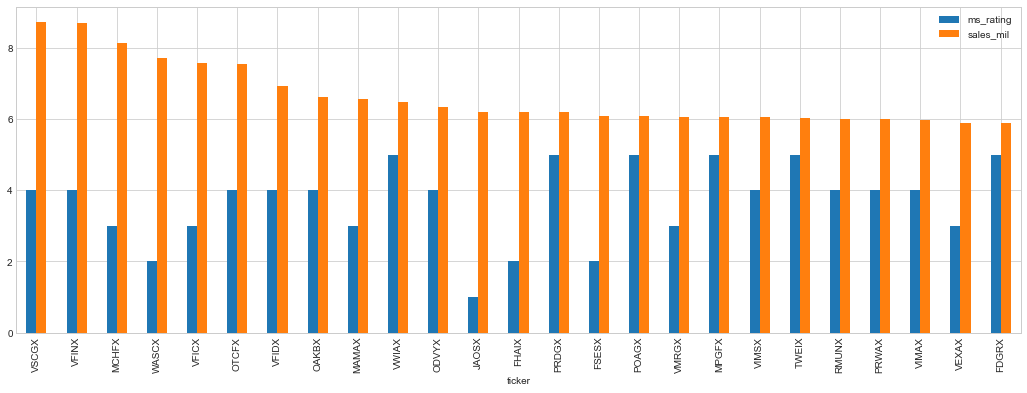

In [53]:
# Clustered Bar Chart - add a "hue" parameter to point to the second value

# sales_by_ticker_df.plot(kind = 'bar', bar_width = 0.35, width = 0.5)

sales_by_ticker_df.plot(kind = 'bar', width = 0.5, rot = 90, figsize = (18,6))


In [56]:
ax = sb.barplot(x = "Ticker", y = "Sales/MS Rating", hue = sales_by_ticker_df.ms_rating, data = sales_by_ticker_df)

ValueError: Could not interpret input 'Ticker'

<AxesSubplot:xlabel='region'>

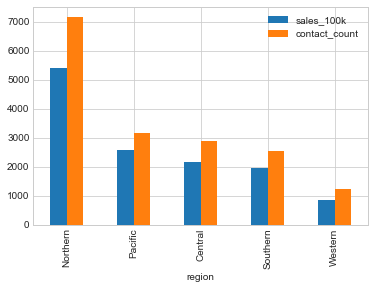

In [45]:
sales_by_region_idx_df.plot(kind = 'bar')